# Racial Bonds

### A statistical analysis of pre-trial detention and bail bond practices in Connecticut

#### by Willie Costello, for the [2020 Ethics4NextGen AI Hackathon](https://dataethics4all.org/ethics4nextgenai-hackathon/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set (optional) display options
plt.rcParams['figure.figsize']=(8.0, 6.0)
%config InlineBackend.figure_format='retina'

## Importing & cleaning the data

The dataset for this analysis is the State of Connecticut's ["Accused Pre-Trial Inmates in Correctional Facilities"](https://data.ct.gov/Public-Safety/Accused-Pre-Trial-Inmates-in-Correctional-Faciliti/b674-jy6w). According to the website, this dataset is "a listing, updated nightly, of individuals being held in Department of Correction facilities while awaiting trial, [on] each day beginning July 1, 2016."

In [3]:
# Read in data
raw_df = pd.read_csv('data/data.csv')

In [4]:
# Preview data
raw_df.head()

,DOWNLOAD DATE,IDENTIFIER,LATEST ADMISSION DATE,RACE,GENDER,AGE,BOND AMOUNT,OFFENSE,FACILITY,DETAINER
0,07/19/2016,ZZSESWRJ,04/20/2016,BLACK,M,16,200000,CRIMINAL ATTEMPT,MANSON YI,NONE
1,07/19/2016,ZZSEWCJC,07/07/2016,HISPANIC,M,18,500000,STEALING A FIREARM DF,MANSON YI,NONE
2,07/19/2016,ZZRCCBBJ,07/06/2016,HISPANIC,M,48,101000,SALE OF NARC/AMPHET BY NON-DEPENDENT F,CORRIGAN CI,NONE
3,07/19/2016,ZZRBBBJC,03/27/2015,BLACK,M,34,1000800,MURDER AF,GARNER,NONE
4,07/19/2016,ZZSZRRRL,04/18/2016,HISPANIC,M,22,95000,THREATENING AM,WALKER RC,NONE


In [5]:
# Rename columns
raw_df.columns = ['date', 'id', 'admit_date', 'race', 'gender', 'age', 'bond', 'offense', 'facility', 'detainer']

In [6]:
# Check datatypes
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771992 entries, 0 to 4771991
Data columns (total 10 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   date        object
 1   id          object
 2   admit_date  object
 3   race        object
 4   gender      object
 5   age         int64 
 6   bond        int64 
 7   offense     object
 8   facility    object
 9   detainer    object
dtypes: int64(2), object(8)
memory usage: 364.1+ MB


In [7]:
# Convert date columns to datetime
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df['admit_date'] = pd.to_datetime(raw_df['admit_date'])

In [8]:
# Check for null values
raw_df.isna().sum()

date          0
id            0
admit_date    0
race          0
gender        0
age           0
bond          0
offense       0
facility      0
detainer      0
dtype: int64

In [9]:
# Check for duplicate rows
raw_df.duplicated().sum()

6292

In [10]:
# Drop duplicate rows
raw_df.drop_duplicates(inplace=True)

While exploring this dataset we noticed that a few inmate IDs were not formatted like the rest, which all begin with the characters `ZZ`. Upon further investigation, these rows are duplicates, which seem to have been entered twice when the inmate moved into the Northern Infirmary facility. As such, we will drop these rows from our dataframe.

In [11]:
# Drop all rows whose inmate ID does not start with ZZ
raw_df.drop(raw_df[~raw_df['id'].str.startswith('ZZ')].index, inplace=True)

In [12]:
# Sort dataframe by date
raw_df.sort_values('date', inplace=True)
raw_df.reset_index(inplace=True, drop=True)

In [13]:
# Various text cleaning transformations
raw_df['race'] = raw_df['race'].str.title()
raw_df['race'].replace('Amer Ind', 'Indigenous', inplace=True)
raw_df['race'].replace('Hispanic', 'Latinx', inplace=True)
raw_df['offense'] = raw_df['offense'].str.replace(',', '')

In [14]:
# Dropping the Detainer column, because irrelevant to our purposes
raw_df.drop('detainer', axis=1, inplace=True)

In [15]:
# Preview cleaned data
raw_df.head()

,date,id,admit_date,race,gender,age,bond,offense,facility
0,2016-07-01,ZZSEHBZZ,2016-02-29,White,M,29,350000,SEXUAL ASSAULT FIRST DEGREE F,MACDOUGALL
1,2016-07-01,ZZRZBHWS,2014-12-30,Black,M,40,601361,ASSAULT ON POLICE OR FIRE OFFICER CF,NORTHERN CI
2,2016-07-01,ZZESBHCH,2016-06-27,Latinx,M,46,25500,INJURY OR RISK OF INJURY TO MINOR F,BRIDGEPORT CC
3,2016-07-01,ZZHJHHZR,2016-06-29,White,F,34,35000,VIOLATION OF PROBATION OR COND DISCHG,YORK CI
4,2016-07-01,ZZECSBWZ,2016-06-24,Black,M,44,12000,SALE OF HALLUCIGEN/NARCOTIC SUBSTANCE F,NEW HAVEN CC


## Transforming the data

From this point on we will work from a copy of our cleaned raw data, to leave this data untouched.

In [16]:
df = raw_df.copy()

### Feature Engineering: Inmate of Colour column

Our dataset encodes race as one of five values: Asian, Black, Indigenous, Latinx, or White. Because our main topic of investigation is racial disparities between White inmates and inmates of colour, here we create a new binary column indicating whether the inmate is White (0) or an inmate of color (1).

In [17]:
# Create new column indicating whether the inmate is White or an inmate of colour
df['ioc'] = np.where(df['race']=='White', 0, 1)

### Feature Engineering: Offense information

The Offense column contains important information for our purposes, recording the controlling offense for which the inmate was arrested and for which the bond amount was set. The column values, however, are poorly formatted, consisting of a number of different individual descriptions that in themselves do not allow us to easily track shared features between the offenses.

In [18]:
# List unique offenses in dataset
offenses = np.unique(df['offense']).tolist()
print('Number of unique offenses recorded in the dataset:', len(offenses))

Number of unique offenses recorded in the dataset: 364


In [19]:
# An example of similar offenses
df[df['offense'].str.startswith('ASSAULT')]['offense'].value_counts()

ASSAULT FIRST DEGREE                 BF     189945
ASSAULT ON POLICE OR FIRE OFFICER     CF    110203
ASSAULT THIRD DEGREE                 AM      91559
ASSAULT SECOND DEGREE                DF      86263
ASSAULT 1ST VICTIM 60 OR OVER        BF      18471
ASSAULT 3RD DEGREE VICTIM OVER 59    AM      11378
ASSAULT 2ND WITH MV WHILE INTOXICATED DF      9086
ASSAULT 2ND VICTIM 60 OR OVER        DF       8532
ASSAULT 2ND DEGREE WITH A FIREARM     DF      6399
ASSAULT ON DOC EMPLOYEE              BF        362
ASSAULT 2ND VICTIM 60+ WITH FIREARM DF         110
Name: offense, dtype: int64

As the above example demonstrates, there are number of different kinds of assault recorded in the Offense column, ranging in degree and object. For data analysis purposes, however, we may have reason to group these various offenses together, so as to contrast them with other offense types.

A straightforward way to simplify the Offense column is simply to take the first word of each description. This method is not perfect, as it will group some different offenses together that shouldn't be, but it will serve our purposes well enough for the moment.

In [20]:
# Abbreviate offense to first word
df['off_abbr'] = df['offense'].str.split(' ').str.get(0)

In [21]:
# List unique offenses in abbreviated list
off_abbrs = np.unique(df['off_abbr']).tolist()
print('Number of unique abbreviated offenses recorded in the dataset:', len(off_abbrs))

Number of unique abbreviated offenses recorded in the dataset: 180


Still a big number of offense types to work with, but much more manageable than before.

It will also be helpful to record the degree of each offense (when indicated) in its own column, so that we can compare different degrees of the same offense with one another.

In [22]:
# Create binary columns indicating first, second, and third degree offenses
df['deg_1'] = df['offense'].str.contains('1ST|FIRST').astype(int)
df['deg_2'] = df['offense'].str.contains('2ND|SECOND').astype(int)
df['deg_3'] = df['offense'].str.contains('3RD|THIRD').astype(int)

# Create single column indicating degree of offense
df['deg'] = df['deg_1'] + (2 * df['deg_2']) + (3 * df['deg_3'])

# For offenses without a degree, list degree as NaN
df['deg'] = df['deg'].replace(0, np.NaN)

### Data Imputation: Bond amount

According to the dataset's webpage, some of the bond amount values are erroneous: "For particularly low values (less than \\$100), this bond amount may be considered a place holder value." Since we are primarily interested in investigating differences in bond amount across inmates, we will treat all bond amounts less than or equal to 100 as missing values, and then impute those missing values with the median bond amount for its particular offense.

In [23]:
# Rename original bond column
df.rename(columns={'bond':'bond_orig'}, inplace=True)

# Recast all bond values less than or equal to 100 as NaNs
df['bond'] = np.where(df['bond_orig'] <= 100, np.NaN, df['bond_orig'])

# Impute missing bond values with median bond values for the offense
df['bond'] = df['bond'].fillna(df.groupby('offense')['bond'].transform('median'))

# Impute remaining missing values with original bond value
df['bond'] = df['bond'].fillna(df['bond_orig'])

# Recast bond value as integer
df['bond'] = df['bond'].astype(int)

### Data Imputation: Admission Date

According to the dataset's webpage, some of the admission date values are also erroneous:

> In some instances, this may reflect an original date of admission to a correctional facility. Generally, if a date is more than one year old, an inmate should not be considered to have been held for the entire duration of that time.

We know from the dataset that some inmates are incarcerated for more longer than a year as they await trial, since they are recorded as being in a correctional facility every day since their admission. However, there are indeed some erroneous admission date values in the dataset. 

We begin by correcting the erroneous admission dates for inmates incarcerated on the first day in our dataset. We assume that admission dates less than two years before the first day in our dataset are true. For admission dates more than two years before the first day, we replace those with the median admission date for inmates incarcerated for less than two years on the first day in our dataset.

In [24]:
# Rename original admission date column
df.rename(columns={'admit_date':'admit_date_orig'}, inplace=True)

In [25]:
# Find median admission date for inmates incarcerated for less than 2 years on first day in dataset
first_admits = df[(df['date']=='2016-07-01') & (df['admit_date_orig'] >= '2014-07-01')]['admit_date_orig'].tolist()
first_admits.sort()
median_admit = first_admits[len(first_admits)//2]

# Create a new column with median admission date
df['median_admit'] = pd.to_datetime(median_admit)

# Replace admission dates older than 2 years before first day in dataset with median
df['admit_date'] = np.where(((df['date']=='2016-07-01') & (df['admit_date_orig'] < '2014-07-01')), df['median_admit'], df['admit_date_orig'])

# Drop median admission date column
df.drop('median_admit', axis=1, inplace=True)

It also turns out that there are some rows in our dataset where the admission date is *after* the current date. We will update these rows so that the current date is one day after the admission date, as it seems it's meant to be.

In [26]:
df['date'] = np.where(df['admit_date'] > df['date'], df['admit_date'] + pd.DateOffset(days=1), df['date'])

The remainder of our erroneous admissions date come from cases where an earlier admission is listed, even though we can see from our data that the inmate was admitted later (i.e., one day before they started appearing in the dataset). We found it too tricky to update these admission dates in our full dataset; instead we created a separate dataframe with an adjusted admission date for each relevant inmate. For any inmate whose admission date is more than thirty days before their first day in prison, we've updated their admission date to be one day before their first day. (We recognize that this method is not perfect, but it is good enough for our purposes, and is much better than leaving these data untouched or dropping them.)

In [27]:
# Find each inmate's first day in prison, by finding the earliest date for each inmate's date of admission
first_days = df.groupby(['id', 'admit_date'])['date'].min()
first_days = pd.DataFrame(first_days).reset_index()

In [28]:
# Calculate the difference between the admission date and their first day
first_days['diff'] = (first_days['admit_date'] - first_days['date']).dt.days

In [29]:
# Replace admission dates more than 30 days before their first day with the day before 
first_days['admit_date_corr'] = np.where(((first_days['diff'] < -30) & (first_days['date'] != '2016-07-01')), 
                                         first_days['date'] - pd.DateOffset(days=1), first_days['admit_date'])

### Data Collation: Inmate dataframe

For the purposes of many of our subsequent analyses, it is necessary to have a dataframe that is grouped by each individual inmate (on each of their individual arrests, for repeat offenders). We create this dataframe below.

In [30]:
# Find each inmate's last day in prison, by finding the latest date for each inmate's date of admission
# (This ensures that repeat offenders are counted for each of their offenses)
last_days = df.groupby(['id', 'admit_date'])['date'].max()
last_days = pd.DataFrame(last_days).reset_index()

# Find each inmate's age when arrested, by finding minimum age for each inmate's date of admission
age_arrested = df.groupby(['id', 'admit_date'])['age'].min()
age_arrested = pd.DataFrame(age_arrested).reset_index()

# Add age arrested to first dataframe
last_days['age_arrested'] = age_arrested['age']

# Add corrected admission date to dataframe
last_days['admit_date_corr'] = first_days['admit_date_corr']

# Merge this dataframe with original dataframe, to include all available information about each inmate
inmate_df = pd.merge(last_days, df, on=['date', 'admit_date', 'id'])

# Drop unneeded columns, rename updated columns
inmate_df.drop(['admit_date', 'admit_date_orig', 'bond_orig', 'age'], axis=1, inplace=True)
inmate_df.rename(columns={'date':'last_date', 'admit_date_corr':'admit_date', 'age_arrested':'age'}, inplace=True)

# Preview merged dataframe
inmate_df.head()

,id,last_date,age,admit_date,race,gender,offense,facility,ioc,off_abbr,deg_1,deg_2,deg_3,deg,bond
0,ZZEBBBCS,2018-09-27,47,2018-08-21,White,M,FAILURE TO APPEAR FIRST DEGREE DF,NORTHERN CI,0,FAILURE,1,0,0,1.0,900000
1,ZZEBBBCS,2019-01-28,47,2018-12-18,White,M,SALE OF HEROIN COC BY NON-DEPENDENT,NORTHERN CI,0,SALE,0,0,0,NaN,1501985
2,ZZEBBBJW,2016-10-21,43,2016-08-24,White,M,INJURY OR RISK OF INJURY TO MINOR F,NEW HAVEN CC,0,INJURY,0,0,0,NaN,15000
3,ZZEBBBJW,2017-07-13,44,2017-07-06,White,M,CRIM VIOL OF PROTECTIVE ORDER AM,HARTFORD CC,0,CRIM,0,0,0,NaN,100000
4,ZZEBBBJW,2018-12-04,46,2018-09-27,White,M,VIOLATION OF PROBATION OR COND DISCHG,HARTFORD CC,0,VIOLATION,0,0,0,NaN,50000


### Feature Engineering: Days Spent Incarcerated column

In [31]:
# Calculate the number of days spent incarcerated
inmate_df['days_spent'] = (inmate_df['last_date'] - inmate_df['admit_date']).dt.days

## Exploring the data

### Racial demographics of pre-trial inmate population

In [32]:
# Count number of inmates of each race on each day
daily_counts = df.groupby(['date', 'race'])['id'].count()
daily_counts = pd.DataFrame(daily_counts).reset_index()

# Pivot dataframe, for conversion & visualization purposes
counts_df = daily_counts.pivot(index='date', columns='race', values='id')

# Calculate total inmates per day
daily_totals = counts_df.sum(axis=1)

# Divide daily counts by daily totals, to calculate daily percentages
pcts_df = counts_df.divide(daily_totals, axis=0)

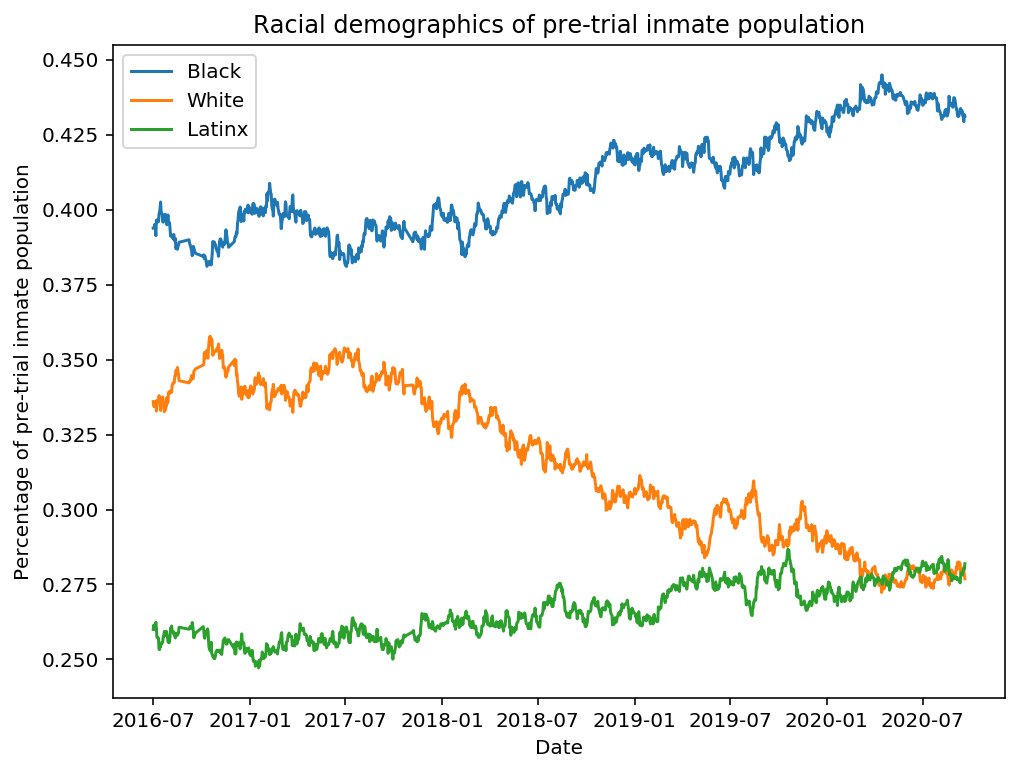

In [55]:
# Plot daily percentages over time
plt.figure()
plt.plot(pcts_df['Black'], label='Black')
plt.plot(pcts_df['White'], label='White')
plt.plot(pcts_df['Latinx'], label='Latinx')
plt.xlabel('Date')
plt.ylabel('Percentage of pre-trial inmate population')
plt.title('Racial demographics of pre-trial inmate population')
plt.legend()
plt.savefig('viz/inmate_population.png', dpi=300)
plt.show()

As we can see here, Black people always make up the largest proportion of the pre-trial inmate population. In 2016, White people made up the next largest proportion, but by 2020 White and Latinx people were incarcerated in roughly equal numbers.

### Racial differences in bond amounts & time spent incarcerated

In [34]:
# Set formatting options
pd.options.display.float_format='{:.0f}'.format

In [35]:
# Calculate mean bond amount and number of days spent incarcerated, grouped by race
inmate_df.groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,76,62471
1,102,104212


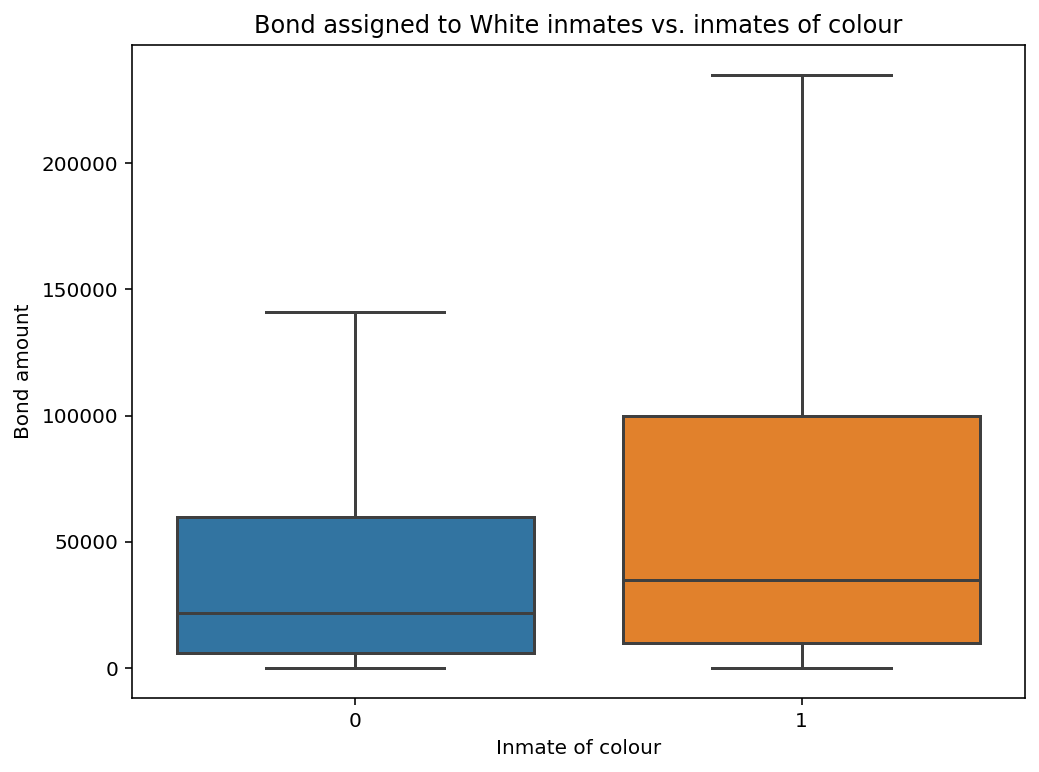

In [36]:
# Visualize it
plt.figure()
sns.boxplot(x='ioc', y='bond', data=inmate_df, showfliers=False)
plt.xlabel('Inmate of colour')
plt.ylabel('Bond amount')
plt.title('Bond assigned to White inmates vs. inmates of colour')
plt.show()

As we can see here, inmates of colour tend to be assigned higher bond amounts and to spend more days in prison than White inmates.

### Controlling for offense type

Is this, however, a result of inmates of colour being arrested for different and more serious types of offenses? Let's investigate this question by looking at a few specific examples.

As can be seen below, the most commonly occurring offense is "Violation of probation or conditional discharge". Let's look at the racial differences for just those inmates arrested for this offense.

In [37]:
# Most commonly occurring offenses
inmate_df['offense'].value_counts().head()

VIOLATION OF PROBATION OR COND DISCHG       10772
CRIM VIOL OF PROTECTIVE ORDER         DF     3872
FAILURE TO APPEAR SECOND DEGREE      AM      3491
INJURY OR RISK OF INJURY TO MINOR      F     2692
ASSAULT THIRD DEGREE                 AM      2163
Name: offense, dtype: int64

In [38]:
# Calculate mean bond and days spent incarcerated for inmates arrested for violation of probation, grouped by race
inmate_df[inmate_df['offense']=='VIOLATION OF PROBATION OR COND DISCHG'].groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,58,48400
1,60,58642


In this case, White inmates tend to spend slightly fewer days in prison than inmates of colour. Despite this, inmates of colour are assigned higher bond amounts.

What if we look at a more serious offense, like assault?

In [39]:
# Create dataframe of all inmates arrested for assault
assault_df = inmate_df[inmate_df['off_abbr']=='ASSAULT']

# Calculate mean bond and days spent incarcerated for inmates arrested for assault, grouped by race
assault_df.groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,86,59111
1,120,102338


What if we control for the degree of the offense?

In [40]:
# Calculate mean bond and days spent incarcerated for inmates arrested for first degree assault
assault_df[assault_df['deg']==1].groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,240,249452
1,277,307840


In [41]:
# Calculate mean bond and days spent incarcerated for inmates arrested for second degree assault
assault_df[assault_df['deg']==2].groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,105,63602
1,103,69988


In [42]:
# Calculate mean bond and days spent incarcerated for inmates arrested for third degree assault
assault_df[assault_df['deg']==3].groupby('ioc')[['days_spent', 'bond']].mean()

,days_spent,bond
ioc,,
0,50,23164
1,56,30941


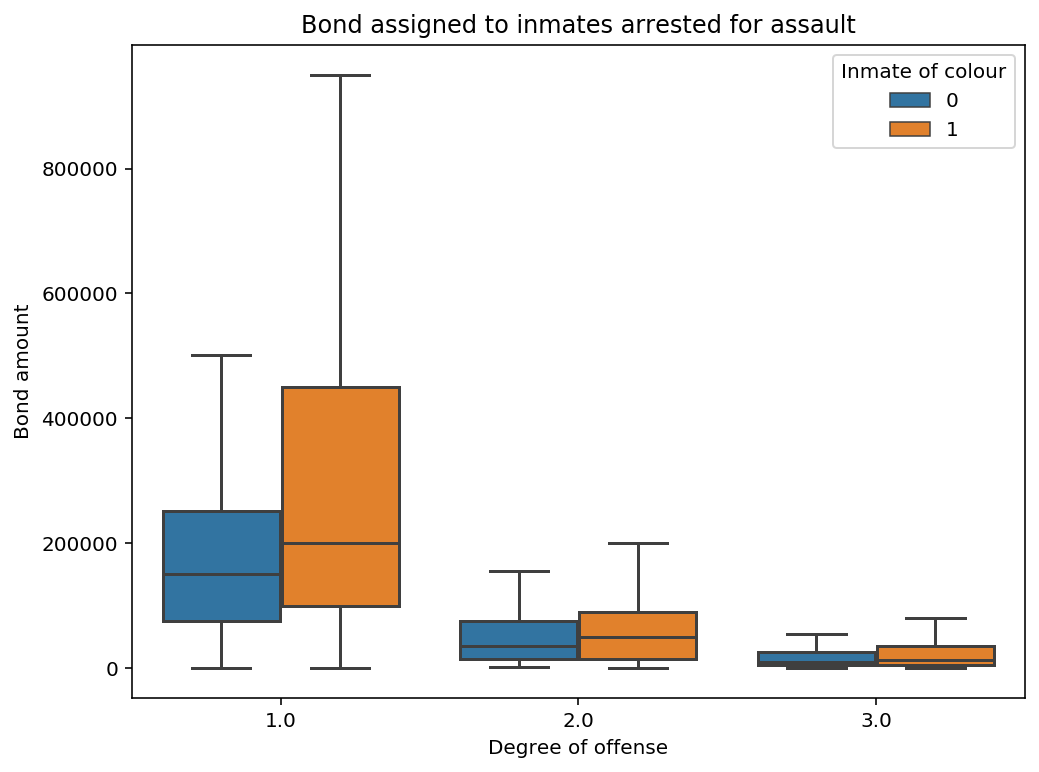

In [43]:
# Visualize it
plt.figure()
sns.boxplot(x='deg', y='bond', hue='ioc', data=assault_df, showfliers=False)
plt.xlabel('Degree of offense')
plt.ylabel('Bond amount')
plt.legend(title='Inmate of colour')
plt.title('Bond assigned to inmates arrested for assault')
plt.show()

Thus, even when the offense is the same, White inmates tend to spend fewer days in prison and be assigned lower bond amounts than inmates of colour.

To be a little more thorough, let's look at the ten most commonly occurring types of offenses and investigate the racial disparities in bond amount.

In [44]:
# Find the ten most commonly occurring types of offenses
inmate_df['off_abbr'].value_counts().head(10)

VIOLATION      10864
ASSAULT         5778
FAILURE         5747
CRIM            5406
LARCENY         3603
CRIMINAL        3330
BURGLARY        2741
INJURY          2693
SALE            2328
INTERFERING     1800
Name: off_abbr, dtype: int64

In [45]:
# Save offense types to a list
top_offenses = inmate_df['off_abbr'].value_counts().head(10).index.tolist()

# Filter data to top offenses
top_offs_df = inmate_df[inmate_df['off_abbr'].isin(top_offenses)]

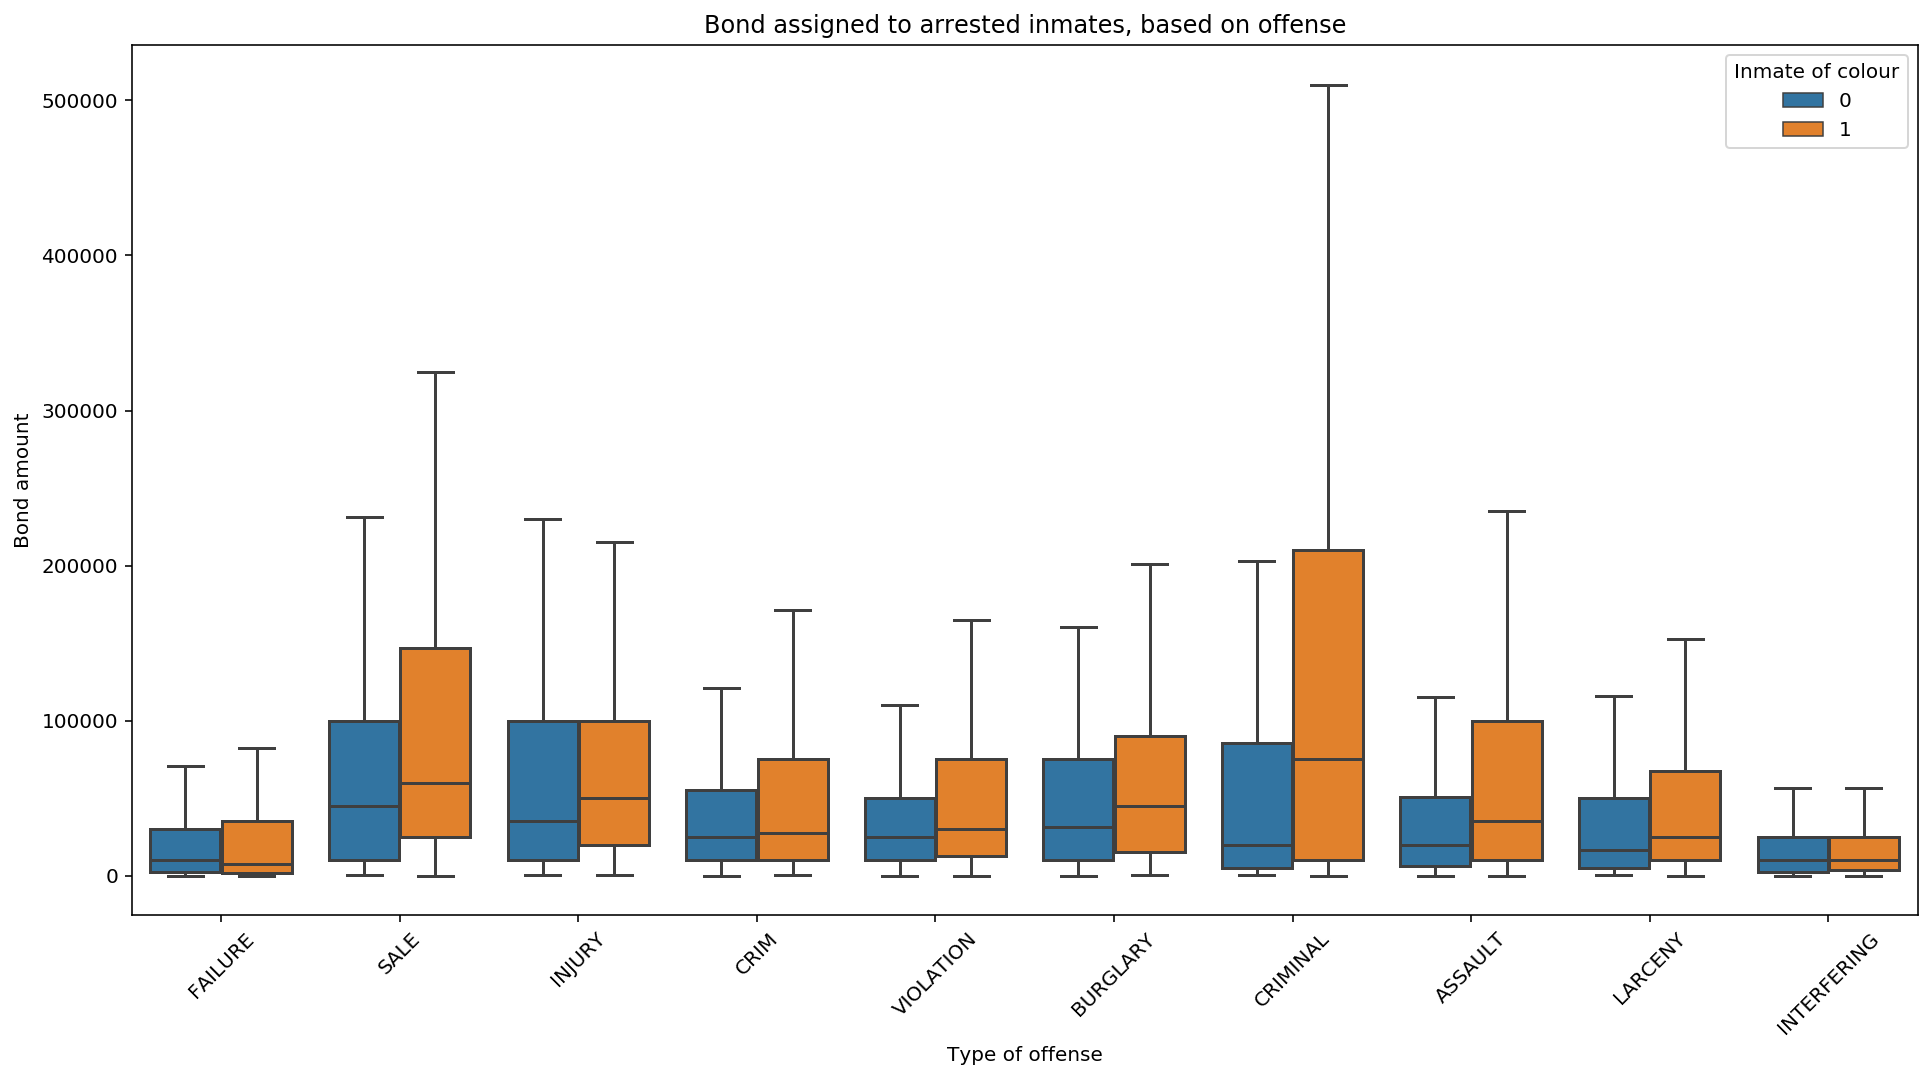

In [46]:
plt.figure(figsize=(16,8))
sns.boxplot(x='off_abbr', y='bond', hue='ioc', data=top_offs_df, showfliers=False)
plt.xlabel('Type of offense')
plt.xticks(rotation=45)
plt.ylabel('Bond amount')
plt.legend(title='Inmate of colour')
plt.title('Bond assigned to arrested inmates, based on offense')
plt.show()

While the pattern is more pronounced in some cases than others, across all these offenses inmates of colour tend to be assigned higher bond amounts than White inmates.

### Controlling for repeat offenders

What else could explain the fact that inmates of colour are assigned higher bond amounts than White inmates? Perhaps it is because inmates of colour are disproportionately repeat offenders, and thus are assigned higher bond amounts than first-time offenders for the same offense?

In [47]:
# Create column indicating whether inmate has been arrested before this offense
inmate_df['repeat'] = inmate_df['id'].duplicated().astype(int)

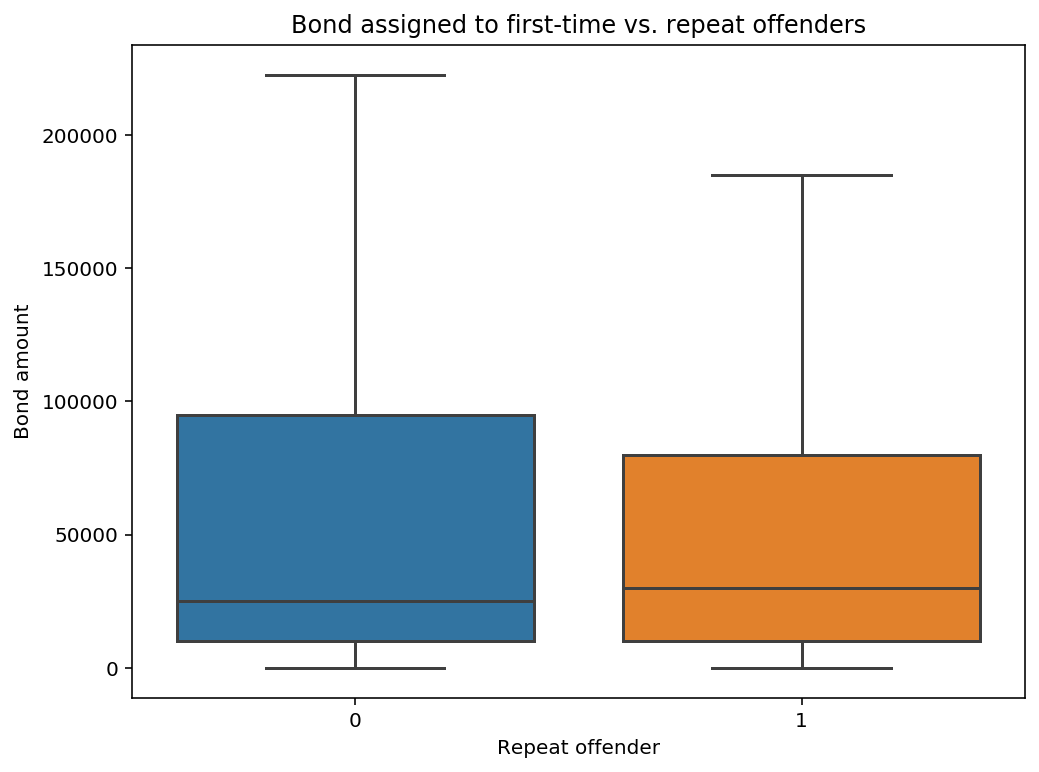

In [48]:
# Visualize it
plt.figure()
sns.boxplot(x='repeat', y='bond', data=inmate_df, showfliers=False)
plt.xlabel('Repeat offender')
plt.ylabel('Bond amount')
plt.title('Bond assigned to first-time vs. repeat offenders')
plt.show()

No striking differences here. The mean bond amount seems slightly higher for repeat offenders than first-timers, but the upper quartile is higher for first-timers.

Perhaps a better question to ask is, Are inmates of colour more likely than White inmates to be repeat offenders?

In [49]:
# Set formatting options
pd.options.display.float_format='{:.3f}'.format

# Count number of first-time & repeat offenders, for each race
repeat_cts = inmate_df.groupby(['ioc', 'repeat'])['id'].count()

# Display relative percentages
repeat_cts.groupby(level=[0]).apply(lambda x: x / x.sum())

ioc  repeat
0    0        0.653
     1        0.347
1    0        0.651
     1        0.349
Name: id, dtype: float64

The answer is no: The relative proportions of first-time and repeat offenders are near identical between White inmates and inmates of colour. As the following plot illustrates, the difference in their bond amounts has nothing to do with whether it is a repeat offense.

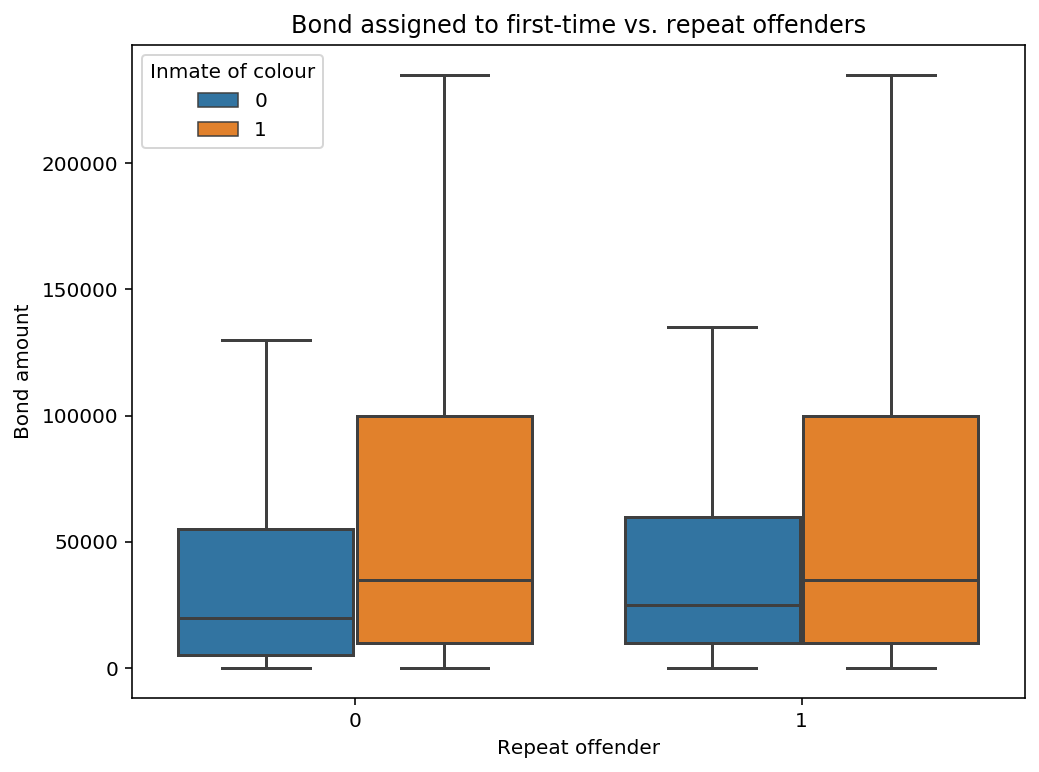

In [50]:
# Visualize it
plt.figure()
sns.boxplot(x='repeat', y='bond', hue='ioc', data=inmate_df, showfliers=False)
plt.xlabel('Repeat offender')
plt.ylabel('Bond amount')
plt.legend(title='Inmate of colour')
plt.title('Bond assigned to first-time vs. repeat offenders')
plt.show()

## Modelling the data

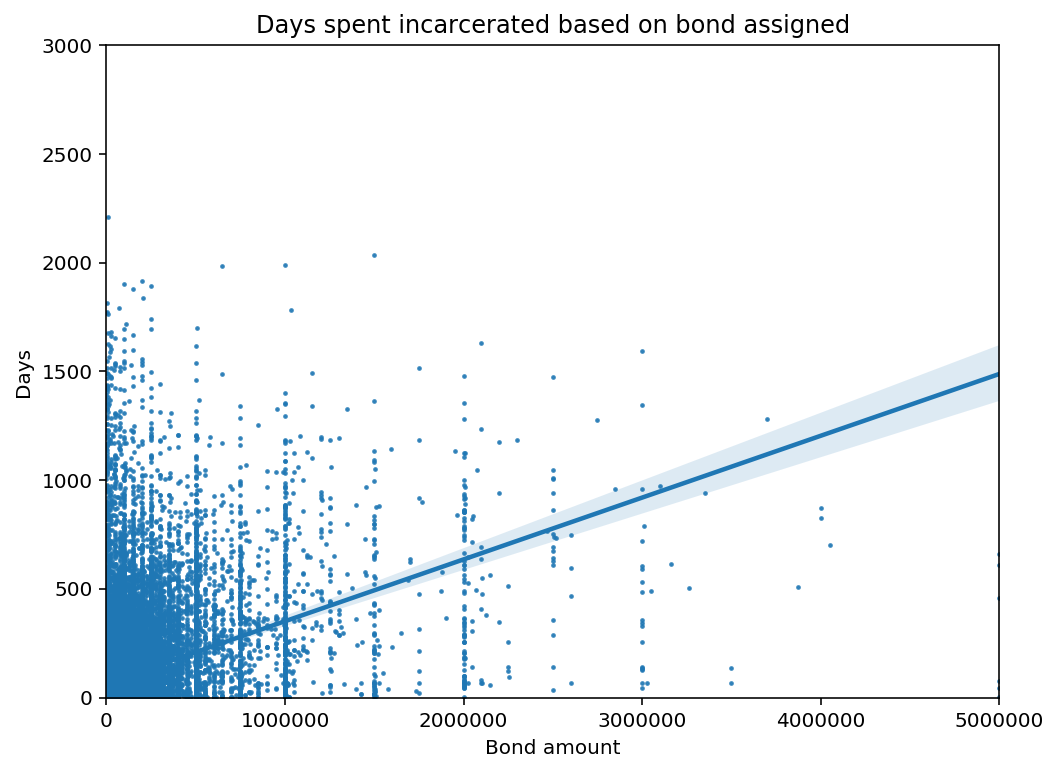

In [51]:
# Visualize relation between bond amount and days spent incarcerated
plt.figure()
sns.regplot(x='bond', y='days_spent', data=inmate_df, scatter_kws={'s':2})
plt.xlabel('Bond amount')
plt.ylabel('Days')
plt.title('Days spent incarcerated based on bond assigned')
plt.xlim((0,5000000))
plt.ylim((0,3000))
plt.show()

## Saving data

In [52]:
df.drop(['admit_date_orig', 'bond'], axis=1).to_csv('data/data_clean.csv', index=False)

In [53]:
inmate_df.to_csv('data/inmate_data.csv', index=False)